## ConstrainedSpace 성능 비교 (1 line sweep) -> Atlas로 결정
* ConstrainedSpace 성능 비교 (1 line sweep) --> Atlas로 결정
  * Projected: 평균 5초 수준, 10초 성공률 70% 수준, std/max error 0.1mm/0.5mm
  * Atlas: 중간값 130ms 수준, 평균 170ms 수준, 10초 성공률 100% 수준, std/max error 0.1mm/0.5mm
  * TangentBundle:  중간값 30 ms 수준, 평균 500ms 수준, 10초 성공률 96% 수준, std/max error 0.5mm/3mm
  
* Constraint - 방향 두개 동시는 속도 현저히 떨어짐
  * Atlas를 써도 느림, TangentBundle 쓰면 빠름
  * BOX를 쓰면 수렴 못함 (discontinuity), PLANE 쓰면 그나마 가능, 
  * PLANE+TangentBundle 쓰면 어느정도 가능해지지만 미수렴 확률 높음, 불안정.
  * 평행점 추가 방식은 그나마 수렴, 하지만 ATLAS는 여전히 느리고 TANGENT는 에러가 너무 큼
  * 평행점 추가 + ATLAS는 긴 거리 이동 시에는 수렴성 매우 낮음
  * 에러 때문에 tol 줄이면 오히려 속도 감소폭이 훨씬 큼
  * 에러 감수하고 평행점 추가 + TANGENT가 현실적.

## set running directory to project source

In [1]:
import os
import numpy as np
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## 4.1 PlanningScene

##### initialize CombinedRobot and GeometryScene

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder

s_builder = SceneBuilder(None)   # create scene builder without detector for virtual scene
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, ((0,0,0), (0,0,0)), None)]
                     , connection_list=[False])
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.show_pose(crob.home_pose)

connection command:
indy0: False


Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


##### add geometries

In [3]:
from pkg.geometry.geometry import *

# add environments (fixed=True for non-movable geometries)
wall = gscene.create_safe(GEOTYPE.BOX, "wall", "base_link", (3,3,0.01), (-0.2,0,0), 
                           rpy=(0,np.pi/2,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
floor = gscene.create_safe(GEOTYPE.BOX, "floor", "base_link", (3,3,0.01), (0,0,0), 
                           rpy=(0,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
wp1 = gscene.create_safe(GEOTYPE.BOX, "wp1", "base_link", (0.1,0.1,0.01), (0.6,-0.3,0),rpy=(0,0,0), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False, parent="floor")
wp2 = gscene.create_safe(GEOTYPE.BOX, "wp2", "base_link", (0.1,0.1,0.01), (0.2,-0.3,0), rpy=(0,0,0), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False, parent="floor")
goal = gscene.create_safe(GEOTYPE.BOX, "goal", "base_link", (0.1,0.1,0.01), (0.3,-0.4,0), 
                          rpy=(0,0,0), color=(0.2,0.2,0.8,1), display=True, fixed=True, collision=False)
 
# add movable (fixed=False for movable geometries)
box1 = gscene.create_safe(GEOTYPE.BOX, "box1", "base_link", (0.05,0.05,0.05), (0.3,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.2,0.2,1), display=True, fixed=False, collision=True)

obstacle = gscene.create_safe(GEOTYPE.BOX, "obstacle", "base_link", (0.05,0.05,0.05), (0.5,0.4,0.031), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=False, collision=True)

##### create PlanningScene

In [4]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

##### create_binder
- Binders (or Actors) are binding points where objects can be attached (or binded)
- Examples are 
  - PlacePlane: plane for object placement
  - Gripper2Tool: 2-finger gripper tool for grasp objects
  - SweepTool: action point to pass waypoints for sweep task

In [5]:
from pkg.planning.constraint.constraint_actor import PlacePlane, Gripper2Tool, SweepFramer

In [6]:
# create PlacePlane on geometry "floor" and "goal"
# when point is not set, the entire upper surface of the geometry becomes valid binding area.
# when point is set, the specific point becomes the only valid binding point.
pscene.create_binder(bname="floor", gname="floor", _type=PlacePlane)
pscene.create_binder(bname="goal", gname="goal", _type=PlacePlane, point=(0,0,0.005))

In [7]:
# add collision boundary for gripper base
# - set link_name="indy0_tcp" to attach the geometry to end-effector link
# - it can be labeled as fixed=True, as it is "fixed" on the indy0_tcp link
gripper =  gscene.create_safe(GEOTYPE.BOX, "gripper", link_name="indy0_tcp", 
                                dims=(0.02,0.1,0.1), center=(0,0,0.05), rpy=(0,0,0), 
                                color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True)

# add gripper fingers - By setting parent="gripper", the position of geometry can be set relative to the parent geometry
finger1 =  gscene.create_safe(GEOTYPE.BOX, "finger1", link_name="indy0_tcp",
                              dims=(0.02,0.02,0.1), center=(0,0.06,0.07), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True, parent="gripper")
finger2 =  gscene.create_safe(GEOTYPE.BOX, "finger2", link_name="indy0_tcp", 
                              dims=(0.02,0.02,0.1), center=(0,-0.06,0.07), rpy=(0,0,0), 
                              color=(0.8,0.2,0.2,0.5), display=True, fixed=True, collision=True, parent="gripper")

# create Gripper2Tool binder
# Gripper2Tool is a 2-finger gripper, which can rotate along z-direction.
# To align the z-direction with the 2 fingers, rotate by 90 degree along roll axis.
# The gripping point is (0,0,0.11) in local coordinate of "gripper" geometry
pscene.create_binder(bname="grip0", gname="gripper", _type=Gripper2Tool, point=(0,0,0.11), rpy=(-np.pi/2,0,0))

In [8]:
# Add virtual (no-collision) sweep face. the point is 0.2 m away from the "indy0_tcp" link
# To match the z-direction with the target surface, the geometry is rotated 180 degrees in pitch-axis.
sweep_face =  gscene.create_safe(GEOTYPE.BOX, "sweep_face", link_name="indy0_tcp", 
                                dims=(0.05,0.05,0.001), center=(0,0,0.2), rpy=(0,np.pi,0), 
                                color=(0.2,0.2,0.8,0.1), display=True, fixed=True, collision=False)
                                 
# create SweepTool binder
pscene.create_binder(bname="sweep_face", gname="sweep_face", _type=SweepFramer, point=(0,0,0), rpy=(0,0,0))

##### create_subject
* Subject describes the tasks in the planning scene.
* There are 2 categories in subject:
  1. Object: The object has grip points and placement points for pick&place task
  2. Task: The task is can be any non-physical task. Check SweepLineTask for example
* The subjects can be composed of multiple action points. Examples are:
  1. Grasp2Point: grasping point for 2-finger gripper. 
  2. PlacePoint: The point to place object.
  3. SweepPoint: A waypoint for SweepLineTask.
  * The above 3 action points inherit DirectePoint, for which the orientation is free along z-axis. 
  * If "point" parameter is not set, the entire upper surface is becomes valid action area.

In [9]:
from pkg.planning.constraint.constraint_subject import Grasp2Point, PlacePoint, SweepFrame
from pkg.planning.constraint.constraint_subject import CustomObject, SweepLineTask

In [10]:
## create box object with grasping points along positive & negative y-direction and placement point in the bottom face
box_obj = pscene.create_subject(oname="box1", gname="box1", _type=CustomObject, 
                             action_points_dict = {
                                 "handle1": Grasp2Point("handle1", box1, [0,0,0], [-np.pi/2,0,0]),
                                 "handle2": Grasp2Point("handle2", box1, [0,0,0], [np.pi/2,0,0]),
                                 "bottom": PlacePoint("bottom", box1, [0,0,-0.026], [0,0,0])})

In [11]:
## create sweep task with 2 waypoints
sweep = pscene.create_subject(oname="sweep", gname="floor", _type=SweepLineTask, 
                             action_points_dict = {"wp1": SweepFrame("wp1", wp1, [0,0,0.005], [0,0,0]),
                                                   "wp2": SweepFrame("wp2", wp2, [0,0,0.005], [0,0,0])}
                             )

##### initialize_state
* initialize_state(robot_pose) updates robot pose and gets corresponding binding status of current scene.
* state.node of ('floor', 0) means the first subject (object) is placed on the floor and the second subject (sweep) has passed 0 waypoints

In [12]:
initial_state = pscene.initialize_state(crob.home_pose)
print(initial_state.node)

('floor', 0)


## 4.2 MotionPlanner

##### MoveitPlanner
* *get_available_binding_dict()* gets available binding states for each subject in a dictionary
* *sample_leaf_state samples()* target state with given available_binding_dict and target node
* *rebind_all()* updates binding state and returns the resultant state
* The motions tested in this section are:
  - pick: move the object to "gripper"
  - place: move the object to "goal"
  - sweep: 
    1) approach to waypoint 1
    2) sweep to waypoint 2
    3) return to home pose

In [13]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)

In [14]:
from pkg.planning.motion.moveit.moveit_planner import PlannerConfig
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType

In [15]:
gtimer=GlobalTimer.instance()
gtimer.reset()
# sweep motion 1 - reach the first waypoint
from_state = initial_state.copy(pscene)
from_state.Q = crob.home_pose
to_node = ("floor", 1)
for _ in range(20):
    available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
    to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
    with gtimer.block("plan"):
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, 
                                                                          plannerconfig=PlannerConfig.RRTstarkConfigDefault)
    if success:
        if np.abs(LastQ[0])<np.pi/2: # else, it will fail in sweep motion
            break
if success:
    pscene.set_object_state(from_state)
    gscene.show_motion(Traj, period=0.05)
    sweep1_state = pscene.rebind_all(binding_list, LastQ)
else:
    print("Solution not found. Please try again, try to find error if it keeps failing.")
    raise(RuntimeError("Motion plan failure"))

try transition motion
transition motion tried: True


In [16]:
print(gtimer)

plan: 	25.9 ms/1 = 25.9 ms (25.913/25.913)



In [17]:
sweep.fix_direction = True

In [18]:
gtimer=GlobalTimer.instance()
gtimer.reset()
from_state = sweep1_state.copy(pscene)
to_node = ("floor", 2)
available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
with gtimer.block("plan"):
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(
        from_state, to_state, redundancy_dict, timeout=50, 
        plannerconfig=PlannerConfig.RRTstarkConfigDefault, 
        cs_type=ConstrainedSpaceType.TANGENTBUNDLE)
print(success)
print(gtimer)

try constrained motion
constrained motion tried: True
True
plan: 	1360.6 ms/1 = 1360.6 ms (1360.555/1360.555)



### visualize trajectory

In [19]:
gtimer.timelist_dict["default"]
gscene.clear_highlight()
gscene.show_motion(Traj, period=0.05)
sweep_face.draw_traj_coords(Traj, "traj_{}".format(sweep_face.name))

[array([[ 9.99999485e-01,  9.36772688e-04, -3.01722462e-04,
          5.99677812e-01],
        [-9.36630749e-04,  9.99999431e-01,  4.61637198e-04,
         -3.00028662e-01],
        [ 3.02141425e-04, -4.61351927e-04,  9.99999816e-01,
          5.14721524e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 9.99999485e-01,  9.36772688e-04, -3.01722462e-04,
          5.99677812e-01],
        [-9.36630749e-04,  9.99999431e-01,  4.61637198e-04,
         -3.00028662e-01],
        [ 3.02141425e-04, -4.61351927e-04,  9.99999816e-01,
          5.14721524e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 9.99998906e-01,  9.50833408e-04, -1.11205231e-03,
          5.89714084e-01],
        [-9.50898380e-04,  9.99999521e-01, -5.74643024e-05,
         -2.99977473e-01],
        [ 1.11198487e-03,  5.85239756e-05,  9.99999359e-01,
          5.12794439e-03],
        [ 0.00000000e+00,  0.00000000e+

### check default

In [ ]:
gtimer=GlobalTimer.instance()
gtimer.reset()
from_state = sweep1_state.copy(pscene)
to_node = ("floor", 2)
available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)
for _ in range(10):
    gtimer.tic("default")
    Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10)
    gtimer.toc("default", stack=True)
print(gtimer)

### test time

In [20]:
import random
from pkg.planning.motion.moveit.moveit_py import ConstrainedSpaceType
cs_types = [ConstrainedSpaceType.PROJECTED, ConstrainedSpaceType.ATLAS, ConstrainedSpaceType.TANGENTBUNDLE]

In [21]:
gtimer = GlobalTimer.instance()
gtimer.reset()
# sweep motion 2 - sweep "floor" to the second waypoint. Constrained motion planning takes longer time
suc_dict = defaultdict(list)
max_dict = defaultdict(list)
std_dict = defaultdict(list)
time_dict = defaultdict(list)
from_state = sweep1_state.copy(pscene)
to_node = ("floor", 2)
available_binding_dict = pscene.get_available_binding_dict(from_state, to_node)
to_state, redundancy_dict = pscene.sample_leaf_state(from_state, available_binding_dict, to_node)

In [22]:
for _ in range(10):    
    random.shuffle(cs_types)
    for cs_type in cs_types:
        gtimer.tic(cs_type.name)
        Traj, LastQ, error, success, binding_list = mplan.plan_transition(from_state, to_state, redundancy_dict, timeout=10, cs_type=cs_type)
        elapsed = gtimer.toc(cs_type.name)
        suc_dict[cs_type.name].append(success)
        time_dict[cs_type.name].append(elapsed)
        if success:
            T_ref=floor.get_tf(crob.home_dict)
            Z_list = []
            for q in Traj:
                T_tool=sweep_face.get_tf(list2dict(q, crob.joint_names))
                Z_list.append(np.matmul(SE3_inv(T_ref), T_tool)[2,3])
            std_dict[cs_type.name].append(np.std(Z_list))
            max_dict[cs_type.name].append(np.max(Z_list)-np.min(Z_list))
    print(gtimer)

try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: True
PROJECTED: 	8351.0 ms/1 = 8351.42 ms (8351.42/8351.42)
TANGENTBUNDLE: 	100.0 ms/1 = 100.064 ms (100.064/100.064)
ATLAS: 	9418.0 ms/1 = 9418.117 ms (9418.117/9418.117)

try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: True
try constrained motion
constrained motion tried: False
PROJECTED: 	8992.0 ms/2 = 4495.971 ms (640.522/8351.42)
TANGENTBUNDLE: 	612.0 ms/2 = 305.916 ms (100.064/511.767)
ATLAS: 	19422.0 ms/2 = 9711.086 ms (9418.117/10004.054)

try constrained motion
constrained motion tried: False
try constrained motion
constrained motion tried: False
try constrained motion
constrained motion tried: False
PROJECTED: 	19240.0 ms/3 = 6413.235 ms (640.522/10247.763)
TANGENTBUNDLE: 	10616.0 ms/3 = 3538.639 ms (100.064/10004.085)
ATLAS: 	29520.0 ms/3 = 9839.94 ms (9418.117/10097

In [23]:
import matplotlib.pyplot as plt
keys = ["PROJECTED", "ATLAS", "TANGENTBUNDLE"]

time_dict PROJECTED: 4172.3721981
time median PROJECTED: 2577.28695869
time_dict ATLAS: 8807.13708401
time median ATLAS: 10006.5795183
time_dict TANGENTBUNDLE: 1120.3234911
time median TANGENTBUNDLE: 51.3545274734


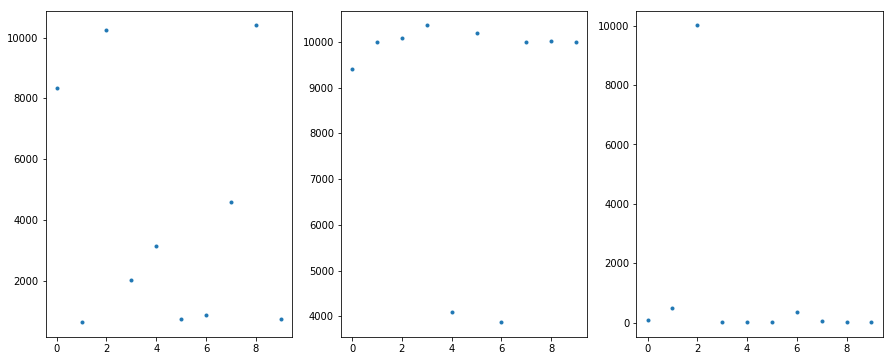

In [24]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = time_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("time_dict {}: {}".format(k, np.mean(v)))
    print("time median {}: {}".format(k, np.median(v)))

suc_dict PROJECTED: 0.8
suc_dict ATLAS: 0.3
suc_dict TANGENTBUNDLE: 0.9


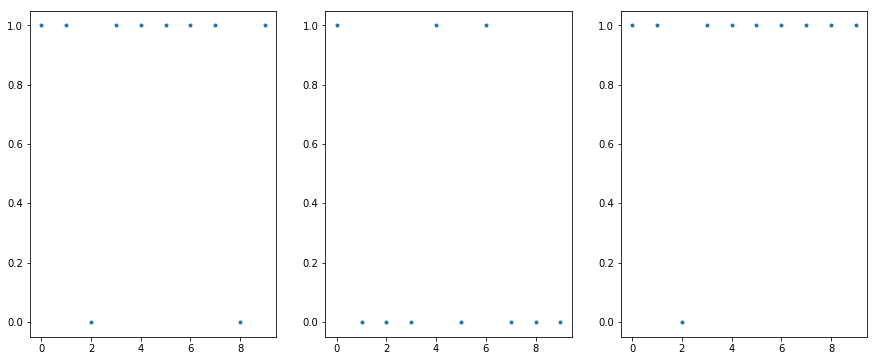

In [25]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = suc_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("suc_dict {}: {}".format(k, np.mean(v)))

std_dict PROJECTED: 9.4476031903e-05
std_dict ATLAS: 0.000139408717534
std_dict TANGENTBUNDLE: 0.000576285243079


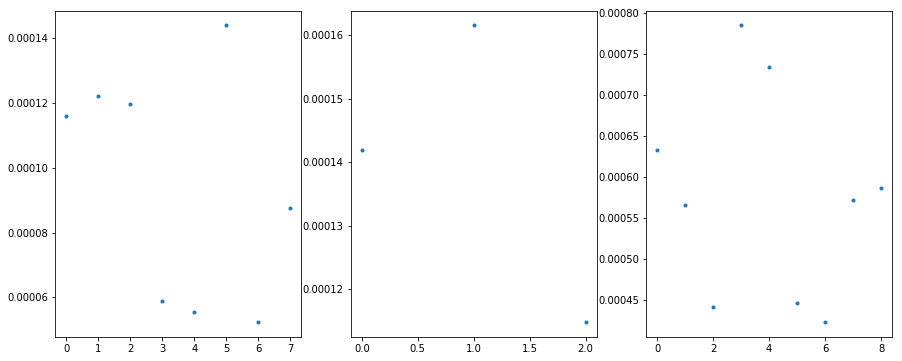

In [26]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = std_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("std_dict {}: {}".format(k, np.mean(v)))

max_dict PROJECTED: 0.000370803948808
max_dict ATLAS: 0.000621854875755
max_dict TANGENTBUNDLE: 0.00257926590836


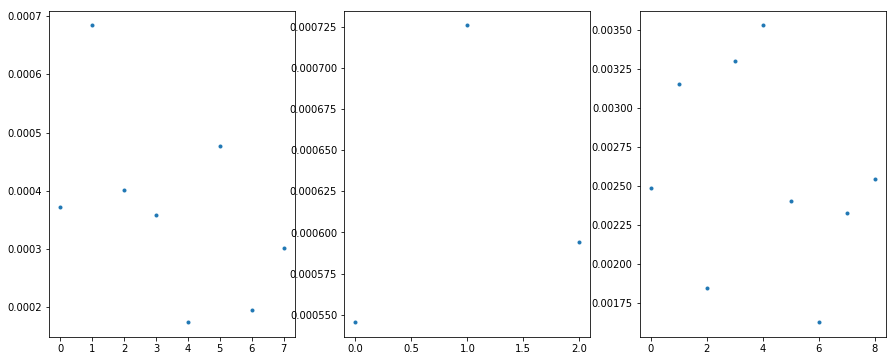

In [27]:
plt.figure(figsize=(15,6))
for i_k, k in enumerate(keys):
    v = max_dict[k]
    plt.subplot(1,3,i_k+1)
    plt.plot(v, '.')
    print("max_dict {}: {}".format(k, np.mean(v)))